***Section 1: Business Understanding***

Question 1: Is there any improvement in the performance of the UNet model by making some changes to the model? 
Question 2: What is the amount of performance improvement with this change? 
Question 3: Is the change worthy enough of the time and resources being spent on training the model? 

In [2]:
%matplotlib inline
#os module to handle paths and directories 
import os
#cv2 library is for OpenCV image manipulation functions 
import cv2
#seaborn is for data visualization
import seaborn 
#numpy for numerical processing 
import numpy as np
#pandas for dataframe manipulation functions 
import pandas as pd 
#for random number generation
import random
#for notebook related function 
import tqdm
from tqdm import notebook
#to create data augmentation pipeline and pytorch 
import albumentations as A
from albumentations import pytorch
#for plotting and data visualization 
import matplotlib.pyplot as plt
#torch for neural network creation and training 
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision

In [3]:
#the images are downloaded and stored into cityscapes_data from where they will be read 
images_dir = r'./cityscapes_data'
train_images_dir = os.path.join(images_dir, 'train')
val_images_dir = os.path.join(images_dir, 'val')
working_dir = '/kaggle/working'

#created paths to store the model weights and logging error and training information 
weights_path = os.path.join(working_dir, 'unet4_weights.pth')
logs_path = os.path.join(working_dir, 'logs')

In [4]:
#the generic class of data generator to create and dispatch batches of training data into the model for training
class Generator(object):
    def __init__(self, images_dir, batch_size, is_augmentation, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(Generator, self).__init__()
        #path from where images are to be taken 
        self.images_dir = images_dir
        #the number of images in particular batch of training data that is presented to the model while training proceeds
        self.batch_size = batch_size
        #rescale factor which is set to 1, ie. no scaling 
        self.rescale = rescale
        #shuffling the data for training, improves performance of the model being trained
        self.shuffle = shuffle
        #whether to apply augmentation or not 
        self.is_augmentation = is_augmentation
        #size of the image that shd be output by this generator 
        self.target_size = target_size
        #processing for creating batches of training data 
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.current_step = 0
        self.count_images = len(self.filenames)
        self.available_steps = int(self.count_images // self.batch_size)
        #image manipulation for data augmentation 
        #this pipeline is composed of rotation by 25 degree counter clockwise, followed of RGBShift/HueSaturation and then by CLAHE/RandomGamma
        self.transforms = A.Compose([
            A.Rotate(25), 
            A.OneOf([
                A.RGBShift(), A.HueSaturationValue()
            ]),
            A.OneOf([
                A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()
            ]), 
        ])
        
    #function for converting data into numerical form and creating a batch of input,output image pairs and returning as numpy array   
    def augmentate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image = image, mask = mask) for (image, mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype = np.float32)
        return batch

    #this function generates batches the details are mentioned within 
    def generate_batch(self):
        start = self.current_step * self.batch_size
        stop = (self.current_step + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        #batch of original images from directory
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        
        #change channeld order to rgb
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        #split original images by image and mask
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch]) 
        
        #resize images 
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        #augmentation
        if self.is_augmentation:
            images_batch = self.augmentate(images_batch)
        
        #set 'channel_first' order
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        
        #rescaling 
        images_batch /= self.rescale
        #resampling 
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    #functions to perform some housekeeping and generating batched at the time of training 
    def __next__(self):
        if self.current_step > self.available_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step += 1
        return images, masks

    def __len__(self):
        return self.available_steps
        

**Data Understanding**

We understand the training images by visualizing them using matplotlib library 

We take the input image i.e. the image that has to be segmented and the output image i.e. the segmented image. We also understand the kind of overlap there exists between the input and output images by adding the pixel values and dividing it by 2 thereby obtaining another image, we are calling here as embedded. 

The segmented images helps us understand the classes of objects that are getting segmented here like road(purple), footpath(light green), sky(light blue), buildings(gray), vehicles(blue), trees(green) and pedestrains(red). 



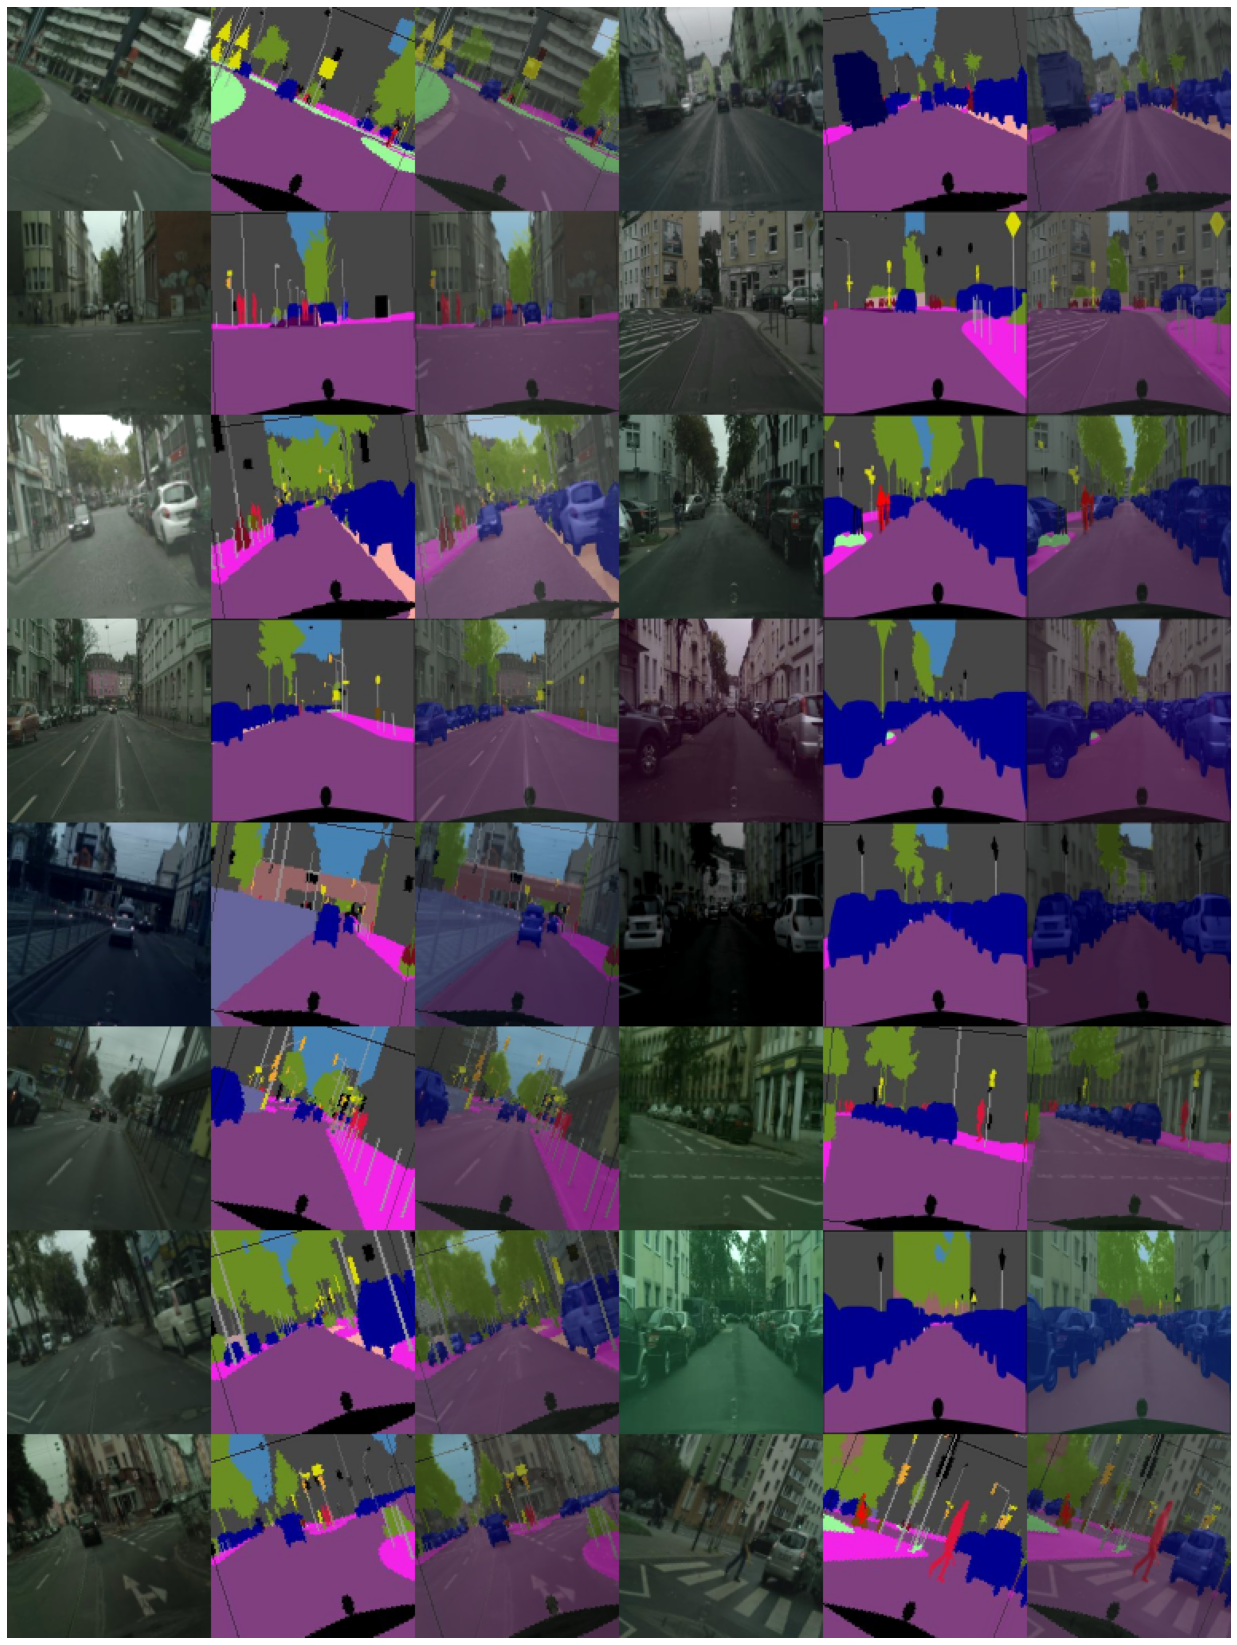

In [5]:
#function to perform data visualization 
def show_examples(num_cols):
    stacks = []
    #create a Generator class object with the given parameters 
    dataloader = Generator(images_dir = train_images_dir, batch_size = 8, is_augmentation = True, rescale = 255.0)
    #for loop iterating over num_cols 
    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))
        embedded = (images + masks) / 2
        stack = np.hstack([images, masks, embedded])
        stacks.append(stack)
    result = np.hstack(stacks)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

show_examples(2)

**Data Modeling**

The model we are using for training is the UNet model for semantic segmentation. The model's architecture and specific details can be found at: https://arxiv.org/abs/1505.04597 

The training of the model takes place with certains parameters such as:
1. Adam optimizer and 
2. Binary cross entropy loss function 

In [12]:
#class named DoubleConv interiting from nn.Module class 
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    #defining the constructor with the following structure as mid_channels = convolution followed by batch normalization followed by 
    #LeakyReLU followed by convolution followed by  batch normalization and then lastly the leakyReLU activation function 

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

     #function to perform the forward pass
    def forward(self, x):
        return self.double_conv(x)

#class named Down inheriting from nn.Module class 
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    #constructor with maxpool_conv = max pooling followed by the DoubleConv object as defined in the previous class 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    #function to perform the forward pass  for this module 
    def forward(self, x):
        return self.maxpool_conv(x)

#class named Up inheriting from nn.Module class
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    #function to perform the forward pass  for this module 
    #more details can be found in the UNet paper 
    def forward(self, x1, x2, x3=None):
        x1 = self.up(x1)
        # input is CHW

        if x3 != None:
            x = torch.cat([x3, x2, x1], dim=1)
        else:
            x = torch.cat([x2, x1], dim=1)

        return self.conv(x)

#class named OutConv inheriting from nn.Module class
class OutConv(nn.Module):
    #constructor with conv = convolutional layer
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    #function to perform the forward pass  for this module 
    def forward(self, x):
        return self.conv(x)


#class named UNet inheriting from nn.Module class
#defines the layers in the Hybrid UNet architecture and their order and forwards pass functions 
#more details on the architecture can be found in the medium article with the figure 
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1088, 512 // factor, bilinear)
        self.up2 = Up(640, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.down1_1 = nn.MaxPool2d(8)
        self.down2_2 = nn.MaxPool2d(2)


    def forward(self, x):
        x1 = self.inc(x)
        x1_1 = self.down1_1(x1)
        x2 = self.down1(x1)
        x2_2 = self.down2_2(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4, x1_1)
        x = self.up2(x, x3, x2_2)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits  

In [13]:
#create the UNet class' object with the following parameters 
unet = UNet(n_channels=3, n_classes=3, bilinear=True)
#initialization of the weights by passing a zero-filled matrix
x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
out = unet(x)

In [26]:
#Adam optimizer for training the model 
#lr is the learning rate and other parameters can be found in the documentation 
optimizer = torch.optim.Adam(params = unet.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

criterion = torch.nn.BCEWithLogitsLoss()

#dice score calculation function 
def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred*target).sum() / (pred+target).sum()

#function to perform training
def training(model, epochs, batch_size):

    #create a train data generation and test data generator with the given parameters 
    train_generator = Generator(images_dir = train_images_dir, batch_size = batch_size, is_augmentation = True, rescale = 255.0)
    test_generator = Generator(images_dir = val_images_dir, batch_size = batch_size, is_augmentation = False, rescale = 255.0)
    
    #use a cuda-enabled gpu or a cpu for training 
    device = torch.device('cpu')
    model.to(device)

    #start with the loss of infinity 
    valid_loss_min = np.Inf

    #iterate through the number of epochs 
    for epoch in range(1, epochs+1):

        train_loss_avg = 0.0
        test_loss_avg = 0.0
        train_dice_coeff = 0.0
        test_dice_coeff = 0.0

        #model training
        model.train()
        for i in range(len(train_generator)):
            #take a batch of training images
            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)
            
            #set the gradient of the optimiser to zero 
            optimizer.zero_grad()
            
            #make the predictions
            train_predictions = model(train_images)
            
            #compare predictions with the ground truth
            train_loss = criterion(train_predictions, train_masks)
            
            #perform the backward pass
            train_loss.backward()

            #calculate the dice score
            train_dice_coeff += dice_coeff(pred = train_predictions, target = train_masks)
            
            #set the calculate gradient and step size 
            optimizer.step()
            
            #add the loss 
            train_loss_avg += train_loss.item()

            #empty the cuda's cache if using cuda 
            torch.cuda.empty_cache()
        
        
            
        #model testing 
        #same as training but without the opimizer gradient calculation and backward pass
        model.eval()
        for i in range(len(test_generator)):

            test_images, test_masks = next(test_generator)
            test_images, test_masks = test_images.to(device), test_masks.to(device)

            test_predictions = model(test_images)

            test_loss = criterion(test_predictions, test_masks)

            test_dice_coeff += dice_coeff(pred = test_predictions, target = test_masks)

            test_loss_avg += test_loss.item()

            torch.cuda.empty_cache()
        
        #calculate average losses and dice coefficient scores 
        train_loss_avg = train_loss_avg/len(train_generator)
        train_dice_coeff = train_dice_coeff/len(train_generator)

        test_loss_avg = test_loss_avg/len(test_generator)
        test_dice_coeff = test_dice_coeff/len(test_generator)
            
        #print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Dice Coeffienct: {:.6f} \tTest Loss: {:.6f} \tTest Dice Coeffienct: {:.6f} '.format(
            epoch, train_loss_avg, train_dice_coeff ,test_loss_avg, test_dice_coeff))
        
        #saving the model
        torch.save(model.state_dict(), 'model_mod.pt')
        

torch.cuda.empty_cache()

#calling the training function on the model with the given parameters 
training(model = unet, epochs = 10, batch_size = 32)

Epoch: 1 	Training Loss: 0.594503 	Training Dice Coeffienct: 0.478840 	Test Loss: 0.584937 	Test Dice Coeffienct: 0.490384 
Epoch: 2 	Training Loss: 0.586145 	Training Dice Coeffienct: 0.467435 	Test Loss: 0.581325 	Test Dice Coeffienct: 0.495658 
Epoch: 3 	Training Loss: 0.581967 	Training Dice Coeffienct: 0.460245 	Test Loss: 0.577757 	Test Dice Coeffienct: 0.478365 
Epoch: 4 	Training Loss: 0.579067 	Training Dice Coeffienct: 0.460719 	Test Loss: 0.573901 	Test Dice Coeffienct: 0.467391 
Epoch: 5 	Training Loss: 0.575595 	Training Dice Coeffienct: 0.471747 	Test Loss: 0.571658 	Test Dice Coeffienct: 0.435904 
Epoch: 6 	Training Loss: 0.574100 	Training Dice Coeffienct: 0.468744 	Test Loss: 0.569950 	Test Dice Coeffienct: 0.432458 
Epoch: 7 	Training Loss: 0.572250 	Training Dice Coeffienct: 0.470921 	Test Loss: 0.565971 	Test Dice Coeffienct: 0.440190 
Epoch: 8 	Training Loss: 0.570089 	Training Dice Coeffienct: 0.471742 	Test Loss: 0.566239 	Test Dice Coeffienct: 0.444916 
Epoch: 9

In [28]:
#creating a UNet object with the given parameters
model = UNet(n_channels=3, n_classes=3, bilinear=True)
#loading the model weights from the model.pt weights file into the UNet object
model.load_state_dict(torch.load("model_mod.pt"))
#observing the object
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

**Evaluate the Results**

Dice co-efficient is used to evaluate the predictions. Dice co-efficient is defined as (2 * Area of Overlap between the input and output image)/(total pixels combined in the input and output images ). 

It is also called as F1 score. 


tensor(0.4588)
tensor(0.4279)


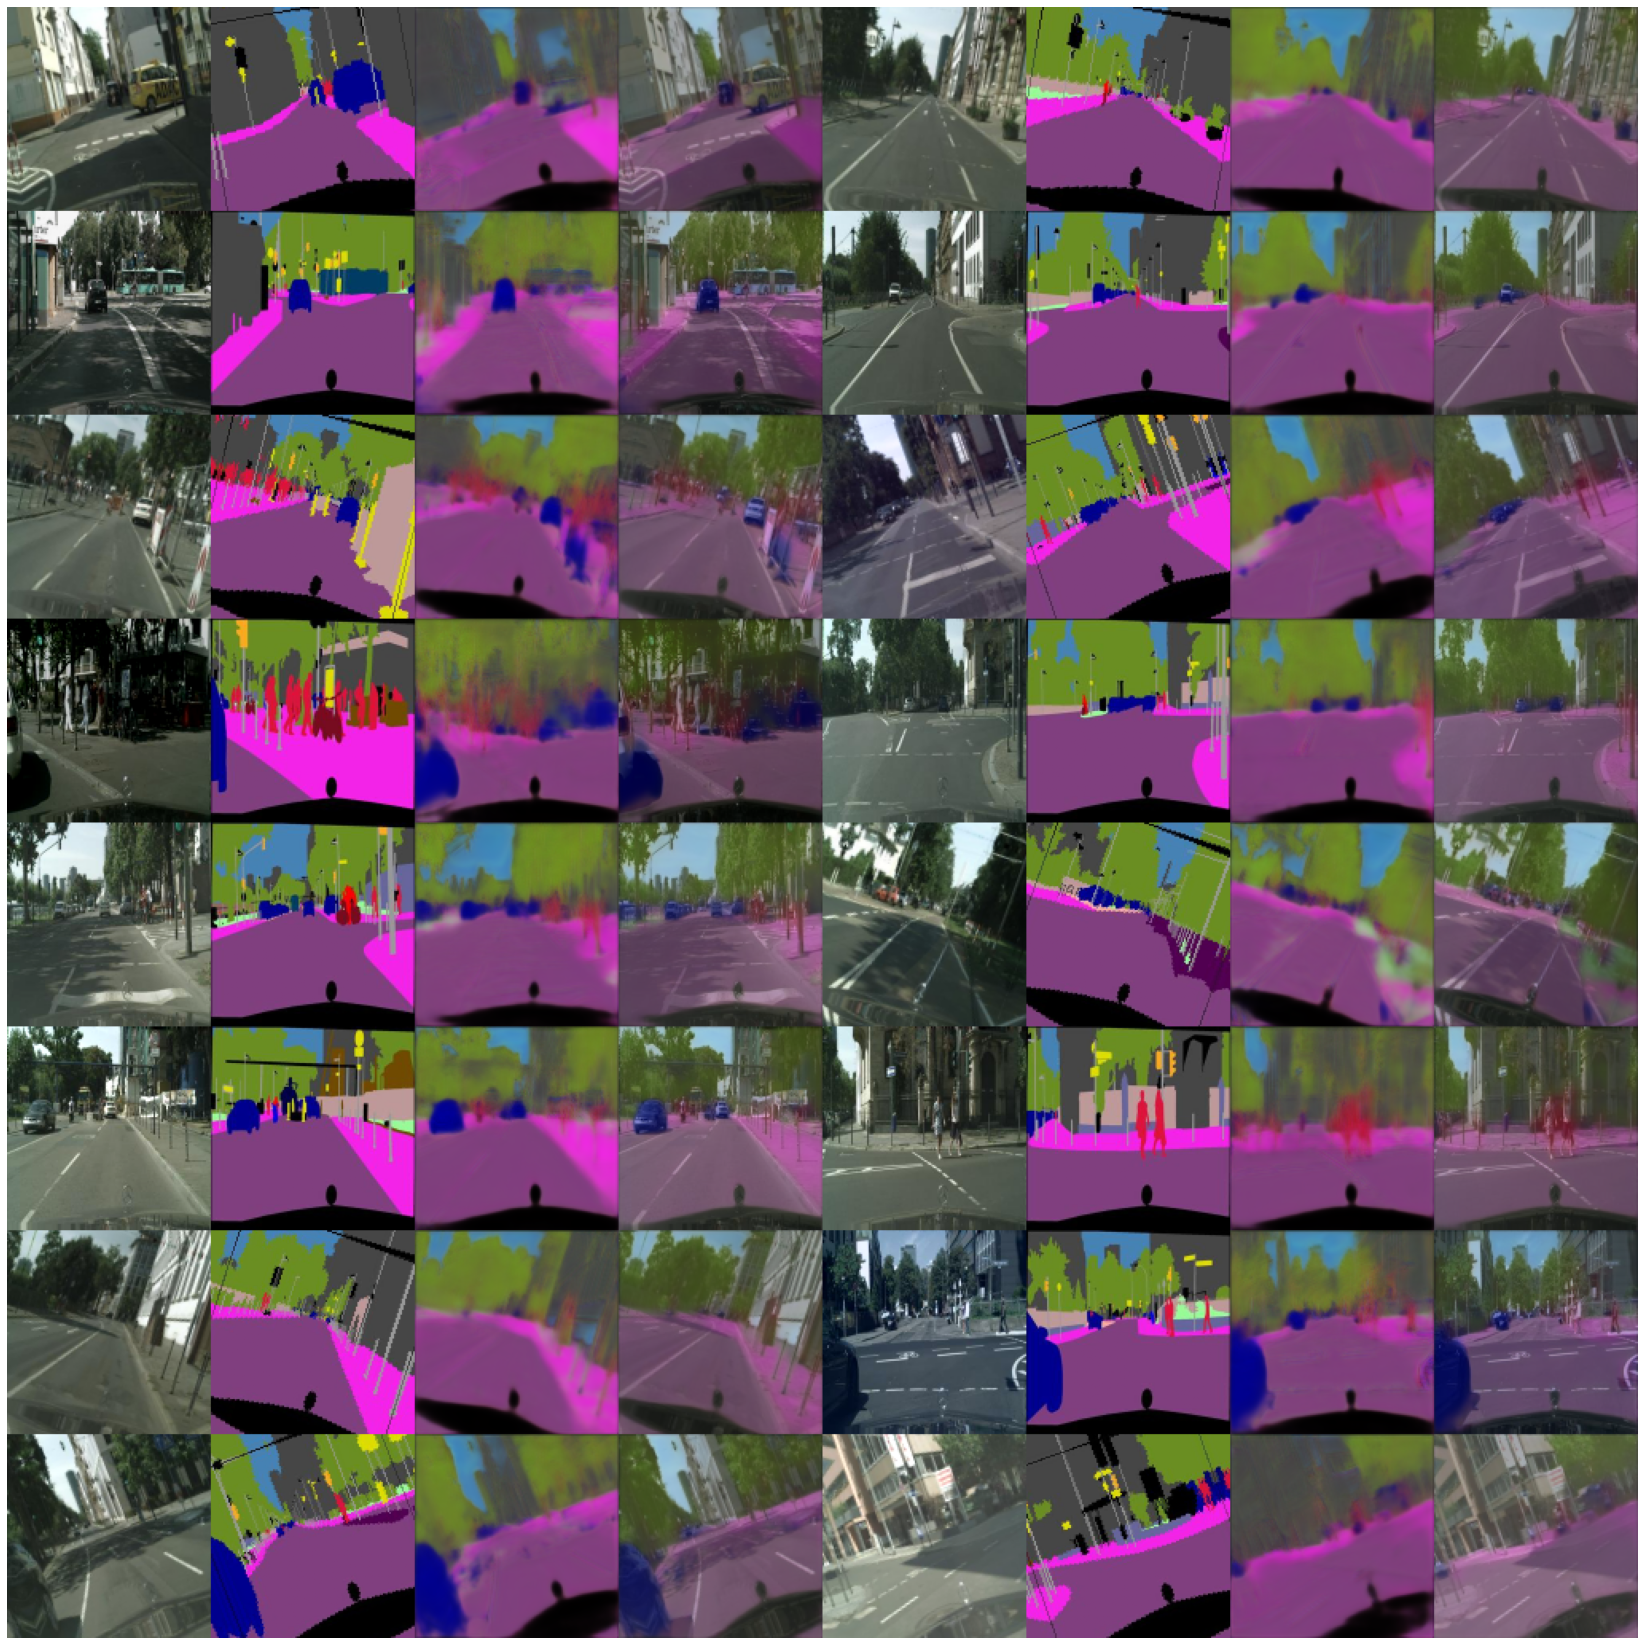

In [29]:
#function to display some input images from the testing dataset with the corresponding predictions from the trained model and 
#the ground truth images 
def show_final_results(num_cols):
    generator = Generator(images_dir = val_images_dir, 
                           batch_size = 8, 
                           is_augmentation = True, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        prediction = model(images)
        dc = dice_coeff(pred = prediction, target = masks)
        print(dc)
        prediction = torch.sigmoid(prediction)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        merged = np.add(images, prediction) / 2
        outputs = np.hstack([images, masks, prediction, merged])
        result.append(outputs)
        
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
    
show_final_results(num_cols = 2)

Question 1: Is there any improvement in the performance of the UNet model by making some changes to the model? 

Yes! 

Question 2: What is the amount of performance improvement with this change? 

The dice score of the plain UNet model was 0.4549 when compared with the Hybrid UNet model for which it is 0.4588. Comparing them with the benchmark (0.77) both the models have low values due to the smaller number of epochs and extremely small size of the dataset.

Question 3: Is the change worthy enough of the time and resources being spent on training the model? 

Investing more time, effort, and money in collecting data and searching for better training mechanisms is important for success in this task and in making self-driving cars safe, and reliable. 

Addition of two layers has increased a lot of paramters, but there is no significant increase in the dice score, but this can't be directly attributed to the change in architecture, it is more due to the small size of dataset and small number of epochs and the difference can become more profound in high resolution images. 
